In [12]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
#https://python-future.org/quickstart.html

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt, numpy as np
import matplotlib.colors as mcolors
import hera_cal, hera_qm, hera_sim
import linsolve
import scipy
import os
import platform

from matplotlib import gridspec
from pyuvdata import UVData
import pyuvdata.utils as uvutils
from datetime import datetime
from IPython.display import Markdown
from hera_cal import io, redcal, abscal, utils, apply_cal
from hera_cal.datacontainer import DataContainer
from copy import deepcopy
from hera_cal.utils import split_pol, split_bl
from importlib import import_module

In [2]:
print("Last executed: %s"%str(datetime.now()))

Last executed: 2019-08-28 19:47:56.598844


 - 
 - 
 - 
 - Criteria:
    1. 
        1. 
        2. 


### Summary


1. 
    1. 
    2. 

In this notebook I will calibrate to simulated data found on NRAO:

PATH: **/lustre/aoc/projects/hera/Validation/test-2.0.0/randsrc_airybeam_Nsrc100_fullband.uvh5**


### Software

In [3]:
print("Python Version:\n \t",platform.sys.version)

for module in ["pyuvdata", "hera_stats", "hera_sim", "hera_qm", "hera_pspec",
               "linsolve", "uvtools", "numpy", "healvis", "healpy"]:
    try:
        _mdl = import_module(module)
    except ModuleNotFoundError:
        pass
    
    if hasattr(_mdl, 'version'):
        gh = getattr(_mdl.version, 'git_hash', None)
    print("Module {:<11}....\tVersion {:<7}.......\tGit {}".format(module, _mdl.__version__, gh))

Python Version:
 	 3.7.1 | packaged by conda-forge | (default, Feb 25 2019, 21:02:05) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Module pyuvdata   ....	Version 1.4.0  .......	Git d1829efacb60da384f64a8f25a280441bfa9d68a
Module hera_stats ....	Version 1.4.0  .......	Git d1829efacb60da384f64a8f25a280441bfa9d68a
Module hera_sim   ....	Version 0.0.1  .......	Git b"b'101444f408b7524dc774ad7ce7c12c77acf6cd45'"
Module hera_qm    ....	Version 1.0    .......	Git 400ee8f93321fb27078533083a2cc46ee56254f9
Module hera_pspec ....	Version 1.0    .......	Git 400ee8f93321fb27078533083a2cc46ee56254f9
Module linsolve   ....	Version 0.0.1  .......	Git 
Module uvtools    ....	Version 0.1.0  .......	Git 92faf0f37a4e33c217b9331d27b3a3397ff95e3e
Module numpy      ....	Version 1.15.0 .......	Git None
Module healvis    ....	Version 1.15.0 .......	Git None
Module healpy     ....	Version 1.12.9 .......	Git None


### Data

The following paths reflect the exact locations of all data used in this test:

(**/lustre/aoc/projects/hera/Validation/test-2.0.0/randsrc_airybeam_Nsrc100_fullband.uvh5**)

In [5]:
path = '/Users/tashaleebillings/Desktop/data/'
image_path = '/Users/tashaleebillings/Desktop/Research/images/'
simfile = 'randsrc_airybeam_Nsrc100_fullband.uvh5'
if not os.path.exists(path+simfile):
    print('File not found.')

## Examine Simulated Data

Use pyuvdata to take a quick look at simulated data.

In [8]:
uvd_val = UVData()
uvd_val.read(path+simfile)
print("Polarization Array: ",uvd_val.polarization_array)
print("Polarization Array: ",uvd_val.get_pols())
print("Number of Antenna: ", len(np.unique(uvd_val.ant_1_array)))

min_ = (np.unique(uvd_val.time_array)).min()*24.*60.*60. #[Sec]
max_ = (np.unique(uvd_val.time_array)).max()*24.*60.*60. #[Sec]
print("Time width of file",end=': ')
print(max_-min_,"sec")

Polarization Array:  [-5 -6 -7 -8]
Polarization Array:  ['xx', 'yy', 'xy', 'yx']
Number of Antenna:  37
Time width of file: 42.949676513671875 sec


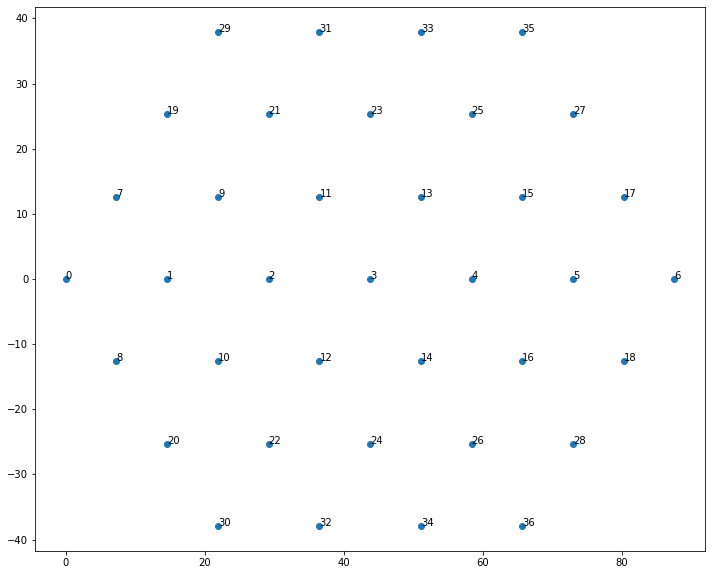

In [54]:
# get antenna positions and the names associated
antpos_xyz, antnum = uvd_val.get_ENU_antpos()

plt.figure(figsize=(12,10))
# Plot antennas with names
plt.plot(antpos_xyz[:,0],antpos_xyz[:,1],'o')
for iant,ant in enumerate(antnum):
    plt.text(antpos_xyz[iant,0],antpos_xyz[iant,1],str(ant))

(-96.35165634155274, 96.35165634155274, -83.48934631347656, 83.42118530273437)

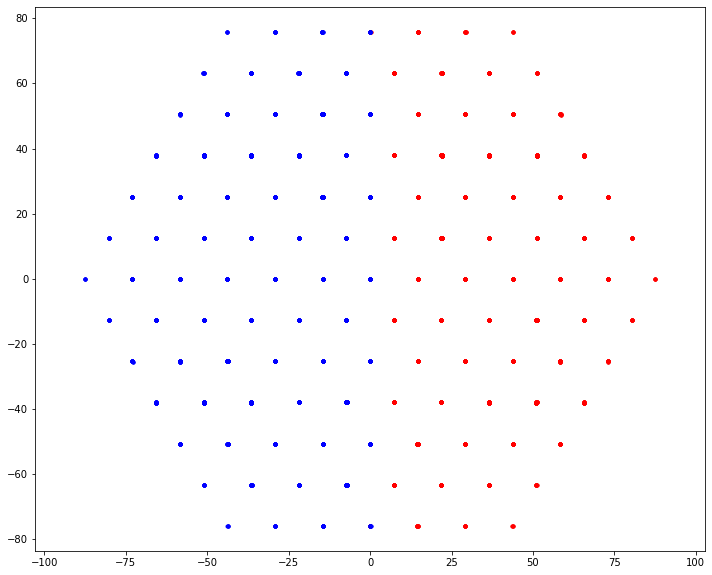

In [53]:
# Plot uv coverage
plt.figure(figsize=(12,10))

plt.plot(uvd_val.uvw_array[:,0],uvd_val.uvw_array[:,1],'r.')
plt.plot(-uvd_val.uvw_array[:,0],uvd_val.uvw_array[:,1],'b.')
plt.axis('equal')

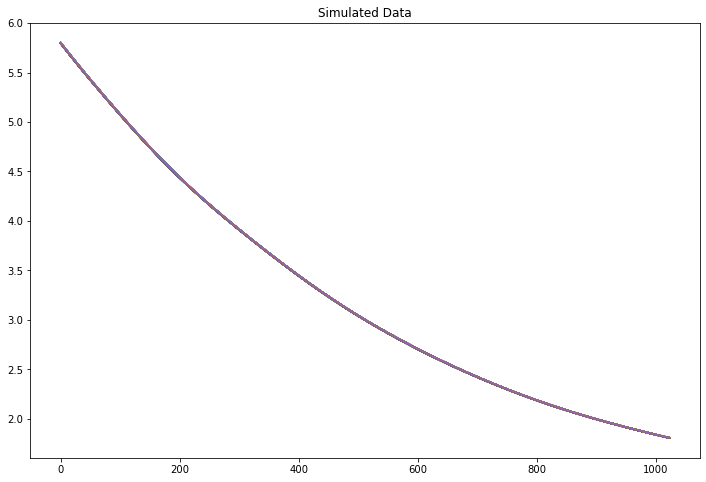

CPU times: user 14.5 s, sys: 1.96 s, total: 16.4 s
Wall time: 16.5 s


In [10]:
%%time

ants_val = np.unique(uvd_val.ant_1_array)

# Check the simulated visibilities of simulated uvh5 data
plt.figure(figsize=(12,8))
plt.title("Simulated Data")
for ant in ants_val:
    uvd_val.select(ant_str='{}x_{}x'.format(ant,ant))
    data_val = (uvd_val.data_array).squeeze()
    plt.plot(data_val.T.real)
    
    del uvd_val
    uvd_val = UVData()
    uvd_val.read(path+simfile)

#plt.savefig("visibility_{}.png".format(filename))
plt.show()

In [11]:
good_ants = list(map(lambda a:str(a),ants_val))
freqs = np.linspace(100,200,num=1024) # [MHz]

### Generate Uncalibrated Data

In [12]:
%%time

hd = io.HERAData(path+simfile)
data, flags, nsamples = hd.read()
np.random.seed(21)
ants = sorted({ant: 0 for bl in data.keys() for ant in split_bl(bl)}.keys())

CPU times: user 1.15 s, sys: 122 ms, total: 1.27 s
Wall time: 1.27 s


In [13]:
dly_rng=(-20, 20) # [ns]

In [99]:
hd.freqs

array([1.00048828e+08, 1.00146484e+08, 1.00244141e+08, ...,
       1.99755859e+08, 1.99853516e+08, 1.99951172e+08])

In [100]:
freqs

array([100.        , 100.09775171, 100.19550342, ..., 199.80449658,
       199.90224829, 200.        ])

In [14]:
%%time

# generate gains with bandpass and delays between -20 and 20 ns
gen_bandpass = hera_sim.sigchain.gen_bandpass(fqs=hd.freqs/1e9, ants=ants, gain_spread=0.1)
# Correct phase of ref ant 0.
rmantphs_gen_bandpass = {}
for i,ant in enumerate(ants):
    if i in np.arange(0,37*2,2):
        rmantphs_gen_bandpass[ant] = gen_bandpass[ant]*gen_bandpass[(0, 'Jxx')].conj()
    else:
        rmantphs_gen_bandpass[ant] = gen_bandpass[ant]*gen_bandpass[(0, 'Jyy')].conj()
#print(rmantphs_gen_bandpass)

# Correct phase of ref ant 0.
gen_delay_phs = hera_sim.sigchain.gen_delay_phs(fqs=hd.freqs/1e9, ants=ants, dly_rng=dly_rng)
rmantphs_gen_delay_phs = {}
for i,ant in enumerate(ants):
    if i in np.arange(0,37*2,2):
        rmantphs_gen_delay_phs[ant] = gen_delay_phs[ant]*gen_delay_phs[(0, 'Jxx')].conj()
    else:
        rmantphs_gen_delay_phs[ant] = gen_delay_phs[ant]*gen_delay_phs[(0, 'Jyy')].conj()
#print(rmantphs_gen_delay_phs)

CPU times: user 16.1 ms, sys: 2.51 ms, total: 18.6 ms
Wall time: 19.8 ms


In [22]:
rmantphs_gen_delay_phs

{(0, 'Jxx'): array([1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]),
 (0, 'Jyy'): array([1.+0.j, 1.+0.j, 1.+0.j, ..., 1.+0.j, 1.+0.j, 1.+0.j]),
 (1, 'Jxx'): array([0.97520051+0.22132323j, 0.97236166+0.23347977j,
        0.96937128+0.24559993j, ..., 0.92002605+0.39185721j,
        0.91506266+0.4033117j , 0.90995667+0.41470333j]),
 (1, 'Jyy'): array([0.99125802+0.13193764j, 0.99124097+0.13206566j,
        0.9912239 +0.13219369j, ..., 0.96530307+0.26113213j,
        0.96526933+0.26125681j, 0.96523558+0.26138148j]),
 (2, 'Jxx'): array([-0.87617851+0.48198673j, -0.88034262+0.47433835j,
        -0.88443996+0.466654j  , ...,  0.50938931-0.86053619j,
         0.51686388-0.8560676j ,  0.52429925-0.85153408j]),
 (2, 'Jyy'): array([-0.99380896-0.11110241j, -0.99345119-0.11425732j,
        -0.9930834 -0.11741108j, ...,  0.9777063 +0.20997711j,
         0.97703467+0.21308039j,  0.97635319+0.21618153j]),
 (3, 'Jxx'): array([ 0.12991799+0.99152474j,  0.12852372+0.99170644j,
         0.12712919+

In [15]:
%%time

#gen_gains = {ai: gen_bandpass[ai] * gen_delay_phs[ai] for ai in ants}
rmantphs_gen_gains = {ai: rmantphs_gen_bandpass[ai] * rmantphs_gen_delay_phs[ai] for ai in ants}

#true_gains = gen_gains
rmantphs_true_gains = rmantphs_gen_gains # adusting reference antenna & others phase

CPU times: user 1.01 ms, sys: 1.12 ms, total: 2.13 ms
Wall time: 1.35 ms


In [18]:
# add random phase offsets to each antenna's gain
phase_offsets = {ant: 2 * np.pi * np.random.rand() for ant in rmantphs_true_gains.keys()}
rmantphs_phase_offsets = {}
for i,ant in enumerate(ants):
    if i in np.arange(0,37*2,2):
        rmantphs_phase_offsets[ant] = phase_offsets[ant] - phase_offsets[(0, 'Jxx')]
    else:
        rmantphs_phase_offsets[ant] = phase_offsets[ant] - phase_offsets[(0, 'Jyy')]

# uncalibratate data and save
#true_gains = {ant: g * np.ones((hd.Ntimes, hd.Nfreqs)) * np.exp(1.0j * phase_offsets[ant])
#              for ant, g in true_gains.items()}
rmantphs_true_gains = {ant: g * np.ones((hd.Ntimes, hd.Nfreqs)) * np.exp(1.0j * rmantphs_phase_offsets[ant])
              for ant, g in rmantphs_true_gains.items()}

In [21]:
rmantphs_phase_offsets

{(0, 'Jxx'): 0.0,
 (0, 'Jyy'): 0.0,
 (1, 'Jxx'): 4.7127055433573535,
 (1, 'Jyy'): -5.362834260634913,
 (2, 'Jxx'): 0.6061070544494973,
 (2, 'Jyy'): 0.35911098960247223,
 (3, 'Jxx'): 5.556713264002794,
 (3, 'Jyy'): -5.263841464738584,
 (4, 'Jxx'): 0.09250716082465332,
 (4, 'Jyy'): -4.895422292069308,
 (5, 'Jxx'): 5.76264161417141,
 (5, 'Jyy'): -4.699100496914066,
 (6, 'Jxx'): 2.8767634660041965,
 (6, 'Jyy'): -4.315039739239781,
 (7, 'Jxx'): -0.1988126993505274,
 (7, 'Jyy'): -3.943789145294436,
 (8, 'Jxx'): 0.7462002346265839,
 (8, 'Jyy'): -0.40122932959836,
 (9, 'Jxx'): 0.2991337250351999,
 (9, 'Jyy'): -2.2957749327810766,
 (10, 'Jxx'): 2.7578887086733883,
 (10, 'Jyy'): 0.7353442230882941,
 (11, 'Jxx'): 3.108553067139418,
 (11, 'Jyy'): -4.882704661911458,
 (12, 'Jxx'): 1.7988798458705006,
 (12, 'Jyy'): -2.356659070718013,
 (13, 'Jxx'): 3.0412493243079277,
 (13, 'Jyy'): -2.094312841754972,
 (14, 'Jxx'): 3.2124688998363413,
 (14, 'Jyy'): -4.344678093663719,
 (15, 'Jxx'): 3.195536482331138

In [20]:
rmantphs_true_gains

{(0,
  'Jxx'): array([[2.67163649e-05+0.j, 2.10090712e-05+0.j, 1.61073417e-05+0.j, ...,
         2.99788601e-05+0.j, 3.31502948e-05+0.j, 3.65265152e-05+0.j],
        [2.67163649e-05+0.j, 2.10090712e-05+0.j, 1.61073417e-05+0.j, ...,
         2.99788601e-05+0.j, 3.31502948e-05+0.j, 3.65265152e-05+0.j],
        [2.67163649e-05+0.j, 2.10090712e-05+0.j, 1.61073417e-05+0.j, ...,
         2.99788601e-05+0.j, 3.31502948e-05+0.j, 3.65265152e-05+0.j],
        [2.67163649e-05+0.j, 2.10090712e-05+0.j, 1.61073417e-05+0.j, ...,
         2.99788601e-05+0.j, 3.31502948e-05+0.j, 3.65265152e-05+0.j],
        [2.67163649e-05+0.j, 2.10090712e-05+0.j, 1.61073417e-05+0.j, ...,
         2.99788601e-05+0.j, 3.31502948e-05+0.j, 3.65265152e-05+0.j]]),
 (0,
  'Jyy'): array([[2.38975255e-05+0.j, 1.82908037e-05+0.j, 1.34744684e-05+0.j, ...,
         2.69485485e-05+0.j, 3.01508200e-05+0.j, 3.35642386e-05+0.j],
        [2.38975255e-05+0.j, 1.82908037e-05+0.j, 1.34744684e-05+0.j, ...,
         2.69485485e-05+0.j, 3.0

In [23]:
%%time
#apply_cal.calibrate_in_place(data=data, new_gains=true_gains, gain_convention='multiply')
apply_cal.calibrate_in_place(data=data, new_gains=rmantphs_true_gains, gain_convention='multiply')
hd.rdate ='' # some python 3 issue
hd.update(data=data)
hd.write_uvfits(path+'uncalibrated_antphsadjusted.2.' + simfile.replace("uvh5","uvfits"),
                force_phase=True, spoof_nonessential=True)

CPU times: user 986 ms, sys: 8.53 ms, total: 995 ms
Wall time: 997 ms


**Plot of Simulated Bandpass Gains**

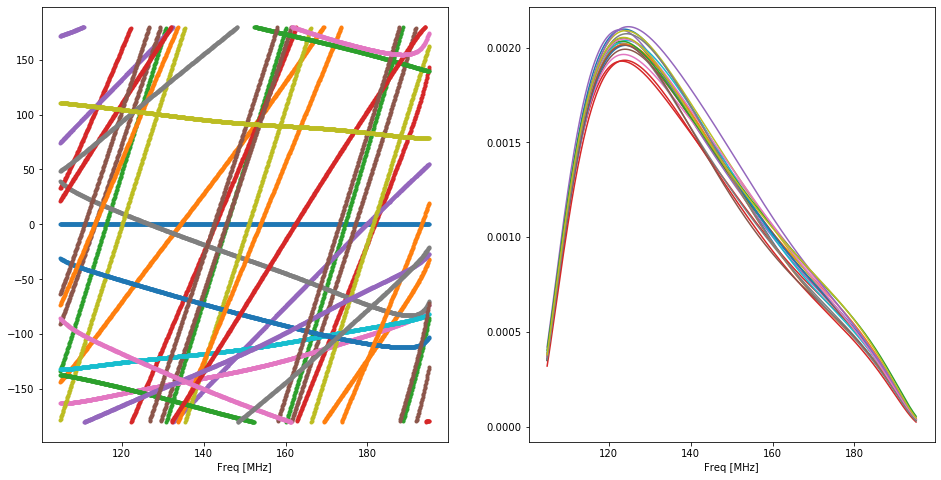

In [110]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

for ant in ants[0::4]:
    ax[0].plot(hd.freqs[50:-50]/1e6,np.angle(np.mean(rmantphs_true_gains[ant], axis=0),deg=True)[50:-50],'.')
    #ax[0].set_title('Combined Gains Phases')
    ax[0].set_xlabel('Freq [MHz]')
    ax[1].plot(hd.freqs[50:-50]/1e6, np.abs(np.mean(rmantphs_true_gains[ant], axis=0))[50:-50])
    #ax[1].set_title('Combined Gains Amplitudes')
    ax[1].set_xlabel('Freq [MHz]')
plt.savefig(image_path+"combined_gains_antphsadjusted.png")

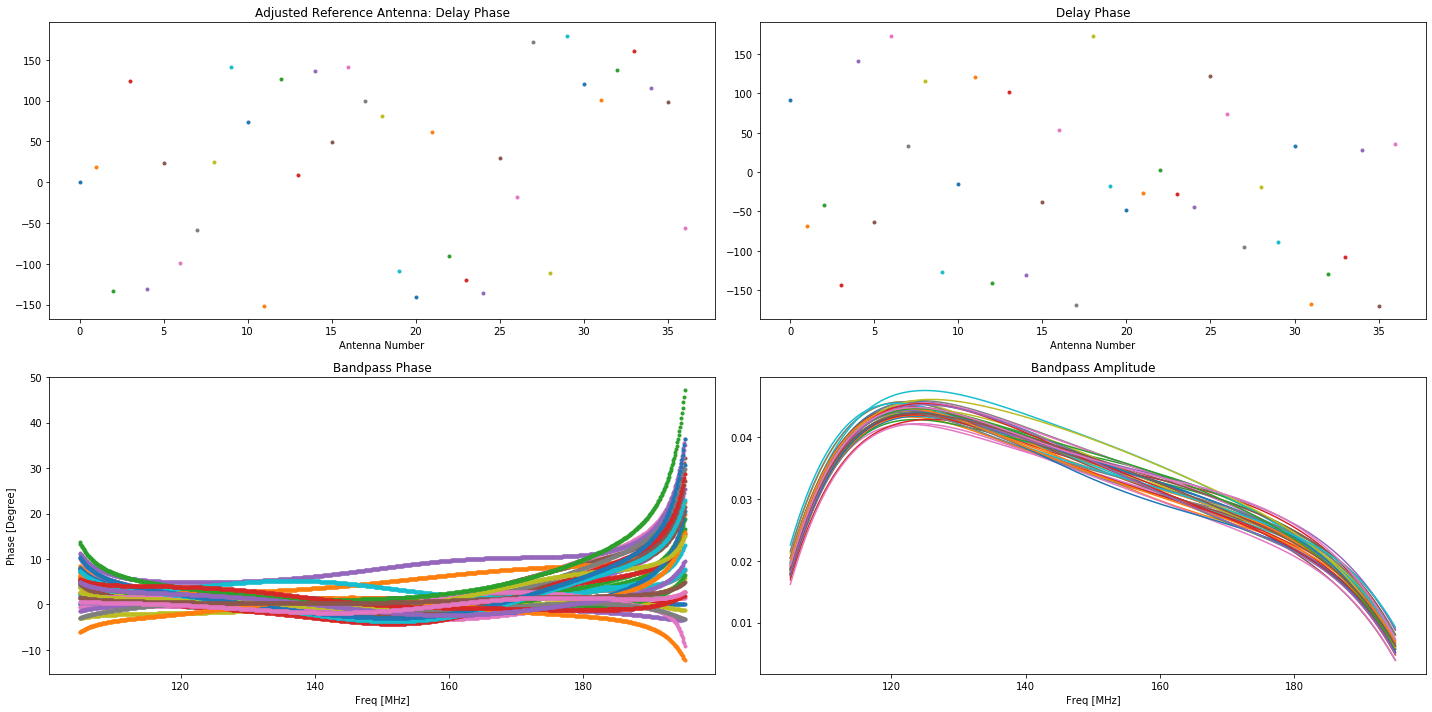

In [109]:
%matplotlib inline

fig, axis = plt.subplots(2,2, figsize=(20,10))

for ant in ants[0::2]:
    #axis[0,0].plot(ant[0], np.angle(np.mean(gen_delay_phs[ant],axis=0),deg=True),'.')
    axis[0,0].plot(ant[0], np.angle(np.mean(rmantphs_gen_delay_phs[ant],axis=0),deg=True),'.')
    axis[0,0].set_title("Adjusted Reference Antenna: Delay Phase")
    axis[0,0].set_xlabel('Antenna Number')
    
    axis[0,1].plot(ant[0], np.angle(np.mean(gen_delay_phs[ant],axis=0),deg=True),'.')
    #axis[0,0].plot(ant[0], np.angle(np.mean(gen_delay_phs[ant]*gen_delay_phs[(0, 'Jxx')].conj(),axis=0),deg=True),'.')
    axis[0,1].set_title("Delay Phase")
    axis[0,1].set_xlabel('Antenna Number')
     
    
    #axis[1,0].plot(uvd_val.freq_array[0,50:-50]/1e6,
                   #np.angle(gen_bandpass[ant]*gen_bandpass[(0, 'Jxx')].conj(),deg=True)[50:-50],'.')
    axis[1,0].plot(hd.freqs[50:-50]/1e6,
                   np.angle(gen_bandpass[ant]*gen_bandpass[(0, 'Jxx')].conj(),deg=True)[50:-50],'.')
    axis[1,0].set_title("Bandpass Phase")
    axis[1,0].set_ylabel('Phase [Degree]')
    axis[1,0].set_xlabel('Freq [MHz]')
    #axis[1,1].plot(uvd_val.freq_array[0,50:-50]/1e6, np.abs(gen_bandpass[ant])[50:-50])
    axis[1,1].plot(hd.freqs[50:-50]/1e6, np.abs(gen_bandpass[ant])[50:-50])
    axis[1,1].set_title("Bandpass Amplitude")
    axis[1,1].set_xlabel('Freq [MHz]')
    
plt.tight_layout()

**Plot of Uncalibrated Data**

The uncalibrated data with all 4 correlation components, [XX,YY,XY,YX], is called:
'/Users/tashaleebillings/Desktop/data/uncalibrated_randsrc_airybeam_Nsrc100_fullband.uvfits'

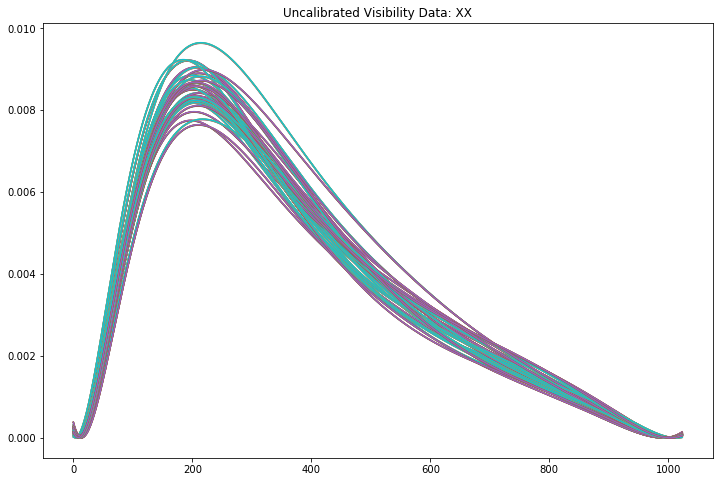

In [33]:
uncal_hd = UVData()
uncal_hd.read(path+'uncalibrated_' + simfile.replace("uvh5","uvfits"))

# Uncalibrated Visibilties for "uncalibrated_randsrc_airybeam_Nsrc100_fullband.uvfits"
ants_val = np.unique(uncal_hd.ant_1_array)

# Check the simulated visibilities of simulated uvh5 data
plt.figure(figsize=(12,8))
plt.title("Uncalibrated Visibility Data: XX")
for ant in ants_val:
    uncal_hd.select(ant_str='{}x_{}x'.format(ant,ant))
    uncal_data_val = (uncal_hd.data_array).squeeze()
    plt.plot(uncal_data_val.T.real)
    
    del uncal_hd
    uncal_hd = UVData()
    uncal_hd.read(path+'uncalibrated_' + simfile.replace("uvh5","uvfits"))

#plt.savefig("visibility_{}.png".format())
plt.show()

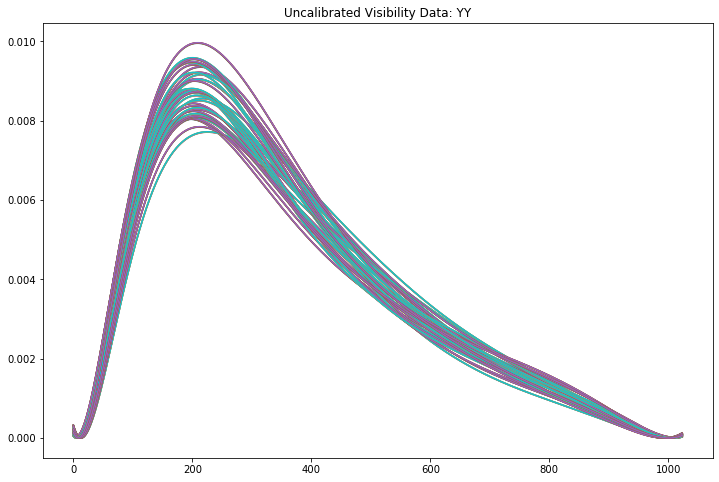

In [182]:
uncal_hd = UVData()
uncal_hd.read(path+'uncalibrated_' + simfile.replace("uvh5","uvfits"))

# Uncalibrated Visibilties for "uncalibrated_randsrc_airybeam_Nsrc100_fullband.uvfits"
ants_val = np.unique(uncal_hd.ant_1_array)

# Check the simulated visibilities of simulated uvh5 data
plt.figure(figsize=(12,8))
plt.title("Uncalibrated Visibility Data: YY")
for ant in ants_val:
    uncal_hd.select(ant_str='{}y_{}y'.format(ant,ant))
    uncal_data_val = (uncal_hd.data_array).squeeze()
    plt.plot(uncal_data_val.T.real)
    
    del uncal_hd
    uncal_hd = UVData()
    uncal_hd.read(path+'uncalibrated_' + simfile.replace("uvh5","uvfits"))

#plt.savefig("visibility_{}.png".format())
plt.show()

In [105]:
# Select xx data 
uncal_hd = UVData()
uncal_hd.read(path+'uncalibrated_' + simfile.replace("uvh5","uvfits"))

uncal_hd.select(ant_str="(0x,1x,2x,3x,4x,5x,6x,7x,8x,9x,10x,11x,12x,13x,14x,15x,16x,17x,18x,19x,20x,21x,22x,23x,24x,25x,26x,27x,28x,29x,30x,31x,32x,33x,34x,35x,36x)_(0x,1x,2x,3x,4x,5x,6x,7x,8x,9x,10x,11x,12x,13x,14x,15x,16x,17x,18x,19x,20x,21x,22x,23x,24x,25x,26x,27x,28x,29x,30x,31x,32x,33x,34x,35x,36x)")
uncal_hd.rdate ='' # some python 3 issue
uncal_hd.write_uvfits(path+'uncalibrated_xx_' + simfile.replace("uvh5","uvfits"),
                      force_phase=True, spoof_nonessential=True)


In [31]:
ant_list=list(map(lambda a:str(a),ants_val))

## Polarization Calibration

Gain Cal Delay Calibration, Gaincal Phase Offset Correction, Bandpass Calibration

To Be Ran In CASA

In [ ]:
import shutil,os,glob
import numpy as np

path = '/Users/tashaleebillings/Desktop/data/'
#uvfits = [path+"uncalibrated_randsrc_airybeam_Nsrc100_fullband.uvfits"]
uvfits = [path+"uncalibrated_antphsadjustedrandsrc_airybeam_Nsrc100_fullband.uvfits"]
for uvfit in uvfits:
    msfile = uvfit.strip('uvfits') + 'MS'
    importuvfits(vis=msfile,fitsfile=uvfit)
    
# I'm not flagging any data

# Create Model Data Column
def makeinitmodel(visib,image_model):
    ft(vis=visib , model =image_model , usescratch = True)

In [ ]:
# Insert Model
makeinitmodel(visib=msfile,image_model=path+"randsrc_airybeam_Nsrc100_fullband_model.model")
#
## Begin Calibration ##
refant = '0'
msin=msfile
image_path = '/Users/tashaleebillings/Desktop/Research/images/'

# Calibration File Name
kc = os.path.basename(msin[2:])  + ".K.cal"
gcphs = os.path.basename(msin[2:])  + ".Gphs.cal"
bc = os.path.basename(msin[2:])  + ".B.cal"


# Delay Calibration
gaincal(vis=msin,caltable=kc,gaintype = 'K' , solint='inf',refant=refant)
plotcal(kc, xaxis='antenna', yaxis='phase', figfile=image_path+'{}.png'.format(kc), showgui=False)

# Phase Offset Calibration
gaincal(vis=msin, caltable=gcphs, gaintype='G', solint='inf', refant=refant,
        calmode='p', gaintable=[kc])
plotcal(gcphs, xaxis='antenna', yaxis='phase', figfile=image_path+'{}.png'.format(gcphs), showgui=False)

# Bandpass Calibration
bandpass(vis=msin, bandtype="B", combine='scan',caltable=bc,
         gaintable=[kc,gcphs], solint='inf', refant=refant)

# Plot of Bandpass Solutions
plotcal(bc, xaxis='chan', yaxis='amp', figfile=image_path+"{}.amp.png".format(bc), showgui=False)
plotcal(bc, xaxis='chan', yaxis='phase', figfile=image_path+"{}.phs.png".format(bc), showgui=False)

# Apply Calibration Solution
applycal(msin, gaintable=[kc,gcphs,bc])

# CREATE .NPZ FILE IN CASA
tb.open(bc)
gains=tb.getcol('CPARAM')
np.savez(bc+'.npz',gains=gains)

tb.open(gcphs)
gains=tb.getcol('CPARAM')
np.savez(gcphs+'.npz',gains=gains)

tb.open(kc)
gains=tb.getcol('FPARAM')
np.savez(kc+'.npz',gains=gains)

# Make CASA mfs Image
imsize_=512
spw_='0:100~924'
stokes_='IQUV'
imagename = os.path.splitext(msin)

tclean(vis=msin,imagename='calibrated_KGB.randsrc_airybeam_Nsrc100_fullband',
       spw=spw_, niter=1, nterms=1, cycleniter=-1, weighting='briggs', stokes='IQUV',
       robust=0, imsize=[imsize_,imsize_], cell='500.0arcsec', specmode='mfs', verbose=True,
       deconvolver="clark", threshold='0.1mJy',interactive=False, pblimit=-1)

viewer("calibrated_KGB.randsrc_airybeam_Nsrc100_fullband.image",
       outfile=image_path+"calibrated_KGB.randsrc_airybeam_Nsrc100_fullband.image.png")

# Make CASA Spectrum Image
imagename = '1024_chan_calibrated_KGB.randsrc_airybeam_Nsrc100_fullband.image'
fitsname = imagename+'.fits'

tclean(vis=msin,imagename[:-6], spw='0',niter=1, cycleniter=-1, weighting='briggs',
       robust=0, imsize=[512,512], cell='500.0arcsec', deconvolver="clark", stokes='IQUV',
       interactive=False, threshold='0.1mJy', pblimit=-1,
       specmode='cube', start=0, width=32, nchan=32)

exportfits(imagename,fitsname)

### Compare Calibration Solutions

Compare the solutions that CASA derived to the ones I generated.

#### Delay Calibration

In [111]:
kc = "/Users/tashaleebillings/Desktop/data/uncalibrated_antphsadjusted.2.randsrc_airybeam_Nsrc100_fullband.MS.K.cal"
npzlist = [kc+'.npz']
delay = np.load(npzlist[0])["gains"]

casa_delay = np.zeros_like(np.load(path+"uncalibrated_antphsadjusted.2.randsrc_airybeam_Nsrc100_fullband.MS.B.cal.npz")["gains"])#(d["gains"])

# Isolate xx and yy components
xxants=ants[0::2] # ants comes from the section called "Generate Uncalibrated Data" 
yyants=ants[1::2]

for ant in ants[0::2]:
    casa_delay[0,:,ant[0]] = np.exp(2j * np.pi * delay[0,0,ant[0]]*1e-9 * hd.freqs)
    casa_delay[1,:,ant[0]] = np.exp(2j * np.pi * delay[1,0,ant[0]]*1e-9 * hd.freqs)

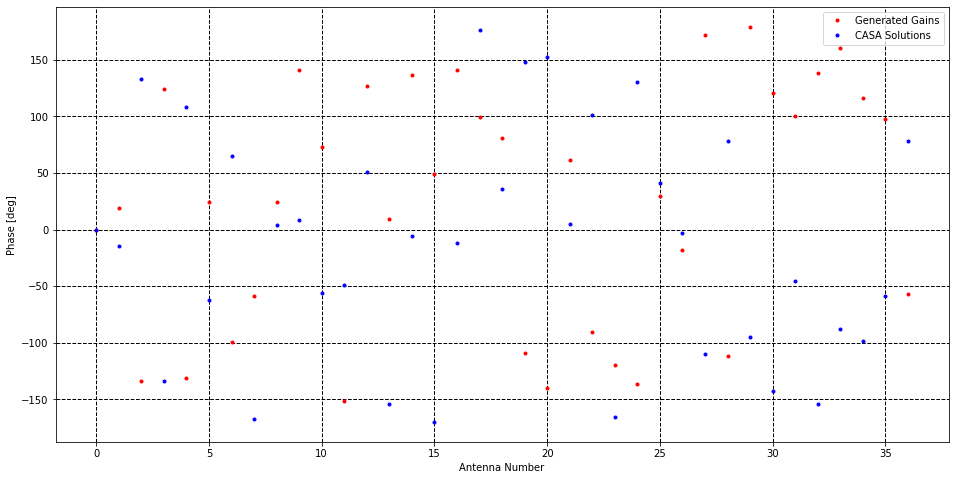

In [112]:
# East-Pol Delay Phase Solution
plt.figure(figsize=(16,8))
for ant in ants[0::2]:
    if ant[0] == 0:
        plt.plot(ant[0], np.angle(np.mean(rmantphs_gen_delay_phs[ant],axis=0),deg=True),'r.',label='Generated Gains')
        plt.plot(ant[0], np.angle(np.mean(casa_delay[0,:,ant[0]],axis=0),deg=True),'b.',label='CASA Solutions')
        #plt.plot(ant[0], (np.angle(np.mean(rmantphs_gen_delay_phs[ant],axis=0),deg=True) - np.angle(np.mean(casa_delay[0,:,ant[0]],axis=0),deg=True)),'g.',label='Gen-CASA')
        plt.grid(color='k', linestyle='--', linewidth=1, axis='both', which='both')
        #plt.title("East-Pol Delay Phase Solution")
        plt.xlabel('Antenna Number')
        plt.ylabel('Phase [deg]')
    else:
        plt.plot(ant[0], np.angle(np.mean(rmantphs_gen_delay_phs[ant],axis=0),deg=True),'r.')
        plt.plot(ant[0], np.angle(np.mean(casa_delay[0,:,ant[0]],axis=0),deg=True),'b.')
        #plt.plot(ant[0], (np.angle(np.mean(rmantphs_gen_delay_phs[ant],axis=0),deg=True) - np.angle(np.mean(casa_delay[0,:,ant[0]],axis=0),deg=True)),'g.')
plt.legend()
plt.savefig(image_path+'CompareSol.'+os.path.basename(kc)+'.eastpol.png')

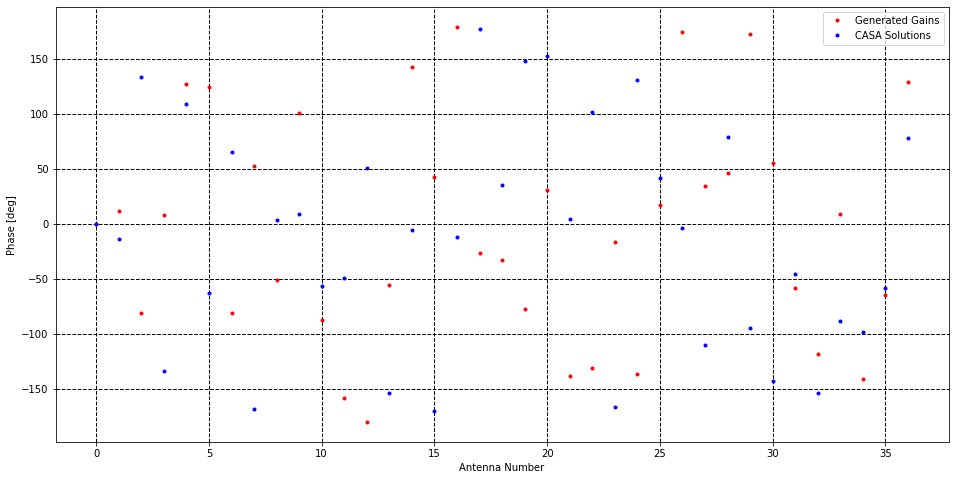

In [113]:
# North-Pol Delay Phase Solution
plt.figure(figsize=(16,8))
for ant in ants[1::2]:
    if ant[0] == 0:
        plt.plot(ant[0], np.angle(np.mean(rmantphs_gen_delay_phs[ant],axis=0),deg=True),'r.',label='Generated Gains')
        plt.plot(ant[0], np.angle(np.mean(casa_delay[1,:,ant[0]],axis=0),deg=True),'b.',label='CASA Solutions')
        plt.grid(color='k', linestyle='--', linewidth=1, axis='both', which='both')
        #plt.title("East-Pol Delay Phase Solution")
        plt.xlabel('Antenna Number')
        plt.ylabel('Phase [deg]')
    else:
        plt.plot(ant[0], np.angle(np.mean(rmantphs_gen_delay_phs[ant],axis=0),deg=True),'r.')
        plt.plot(ant[0], np.angle(np.mean(casa_delay[0,:,ant[0]],axis=0),deg=True),'b.')
plt.legend()
plt.savefig(image_path+'CompareSol.'+os.path.basename(kc)+'.northpol.png')

#### Phase Offset Calibration

In [6]:
gcphs = path+"uncalibrated_antphsadjusted.2.randsrc_airybeam_Nsrc100_fullband.MS.Gphs.cal"
npzlist = [gcphs+'.npz']
offset = np.load(npzlist[0])["gains"]

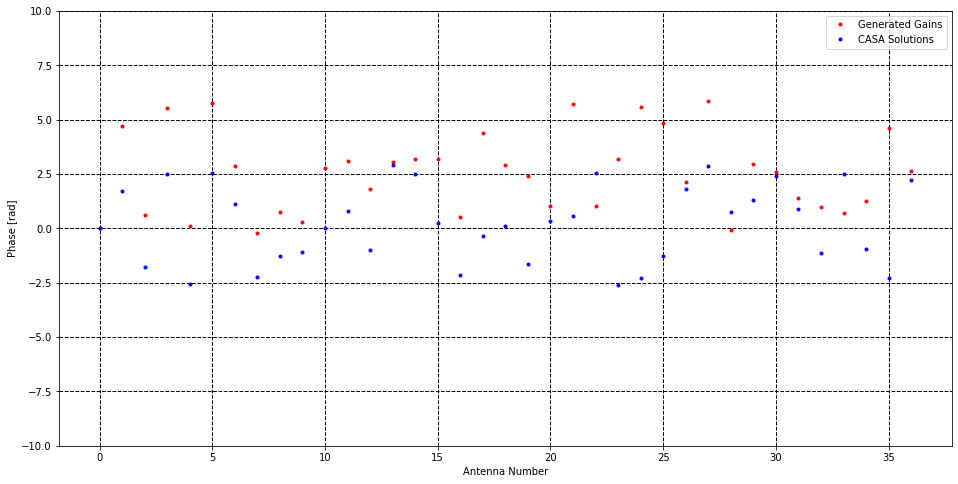

In [45]:
# East-Pol Phase Offset Solution
plt.figure(figsize=(16,8))
plt.ylim(-10,10)
for ant in ants[0::2]:
    if ant[0] == 0:
        plt.plot(ant[0], rmantphs_phase_offsets[ant],'r.',label='Generated Gains')
        plt.plot(ant[0], np.angle(offset[0,0,ant[0]],deg=False),'b.',label='CASA Solutions')
        plt.grid(color='k', linestyle='--', linewidth=1, axis='both', which='both')
        #plt.title("East-Pol Delay Phase Solution")
        plt.xlabel('Antenna Number')
        plt.ylabel('Phase [rad]')
    else:
        plt.plot(ant[0], rmantphs_phase_offsets[ant],'r.')
        plt.plot(ant[0], np.angle(offset[0,0,ant[0]],deg=False),'b.')
plt.legend()
plt.savefig(image_path+'CompareSol.'+os.path.basename(gcphs)+'.eastpol.png')

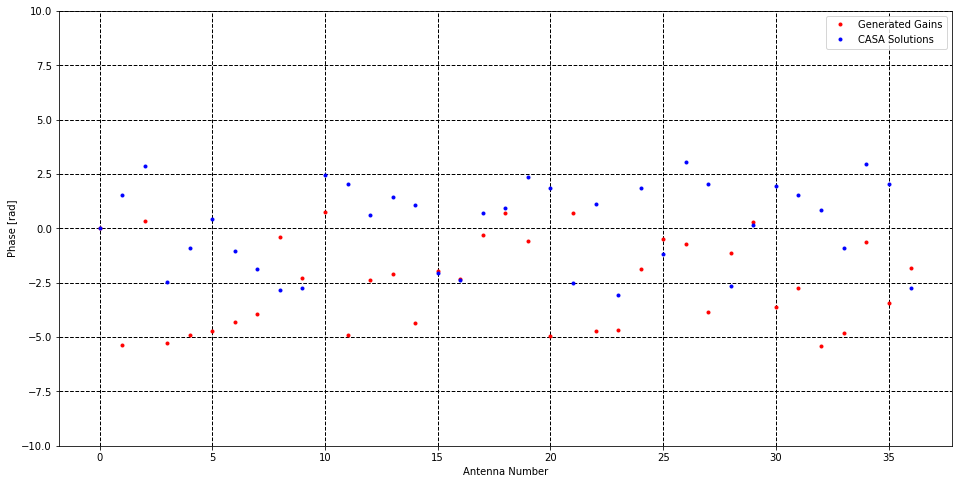

In [54]:
# North-Pol Phase Offset Solution
plt.figure(figsize=(16,8))
plt.ylim(-10,10)

for ant in ants[1::2]:
    if ant[0] == 0:
        plt.plot(ant[0], rmantphs_phase_offsets[ant],'r.',label='Generated Gains')
        plt.plot(ant[0], np.angle(offset[1,0,ant[0]],deg=False),'b.',label='CASA Solutions')
        plt.grid(color='k', linestyle='--', linewidth=1, axis='both', which='both')
        #plt.title("East-Pol Delay Phase Solution")
        plt.xlabel('Antenna Number')
        plt.ylabel('Phase [rad]')
    else:
        plt.plot(ant[0], rmantphs_phase_offsets[ant],'r.')
        plt.plot(ant[0], np.angle(offset[1,0,ant[0]],deg=False),'b.')
plt.legend()
plt.savefig(image_path+'CompareSol.'+os.path.basename(gcphs)+'.northpol.png')

In [7]:
offset.shape

(2, 1, 37)

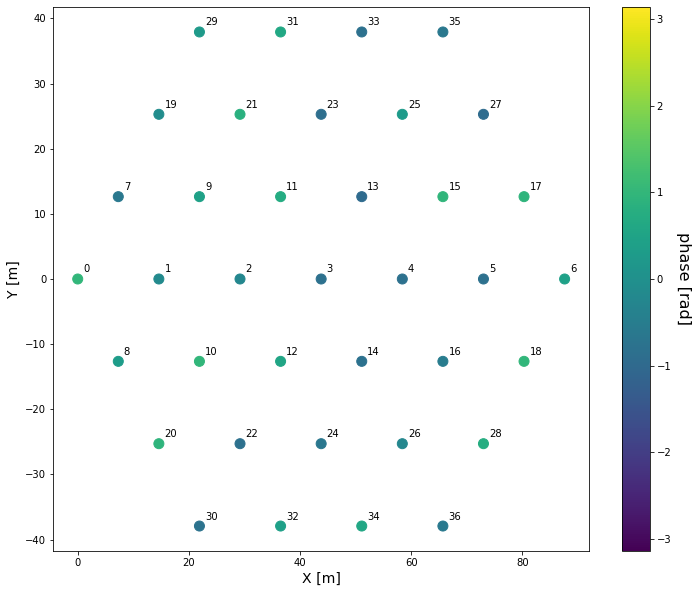

In [65]:
phs = np.array([ph.real for ph in offset])

plt.figure(figsize=(12,10))

cax = plt.scatter(antpos_xyz[:, 0], antpos_xyz[:, 1], c=phs[0, 0, :], s=100,
                     cmap='viridis', vmin=-np.pi, vmax=np.pi)
# Plot antennas with names
for iant,ant in enumerate(antnum):
    plt.text(antpos_xyz[iant,0]+1,antpos_xyz[iant,1]+1,str(ant))
plt.xlabel("X [m]", fontsize=14)
plt.ylabel("Y [m]", fontsize=14)
clb = plt.colorbar(cax)
clb.set_label("phase [rad]", rotation=270, size=16, labelpad=20)

#### Bandpass Amplitude and Phase Solutions

In [88]:
bc = "/Users/tashaleebillings/Desktop/data/uncalibrated_antphsadjusted.2.randsrc_airybeam_Nsrc100_fullband.MS.B.cal"
npzlist = [bc+'.npz']
d = np.load(npzlist[0])

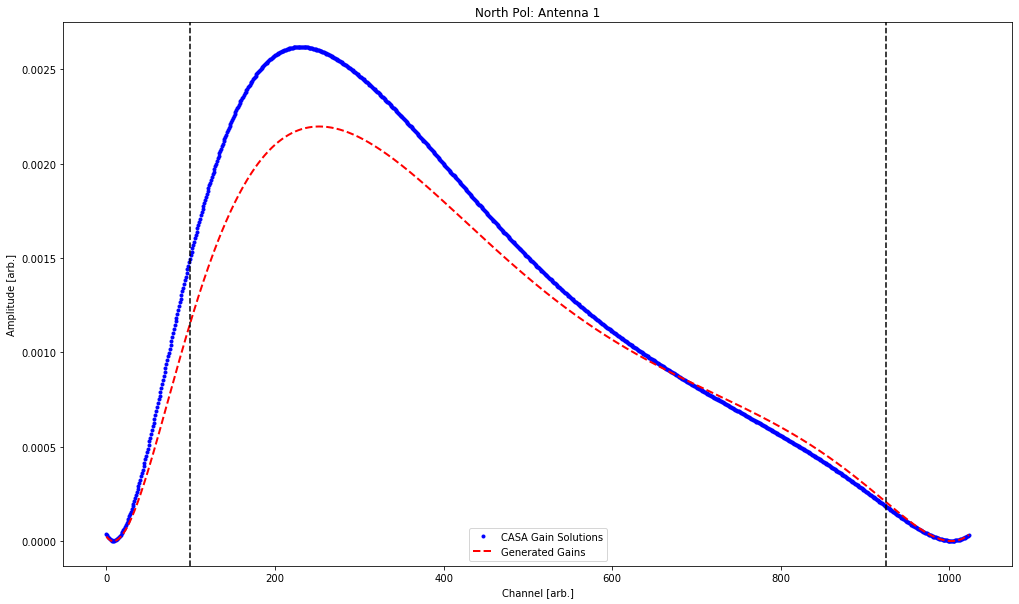

In [115]:
plt.figure(figsize=(17,10))
plt.title("North Pol: Antenna 1")
plt.plot(np.abs(d['gains'][1,:,1]),'b.',label='CASA Gain Solutions',lw=2)
plt.plot(np.abs(rmantphs_gen_bandpass[ants[1]]),'r--',label='Generated Gains',lw=2)

plt.axvline(99, color='k', linestyle='--')
plt.axvline(925, color='k', linestyle='--')
#plt.ylim(0.0,0.06)
plt.xlabel('Channel [arb.]')
plt.ylabel('Amplitude [arb.]')
plt.legend()

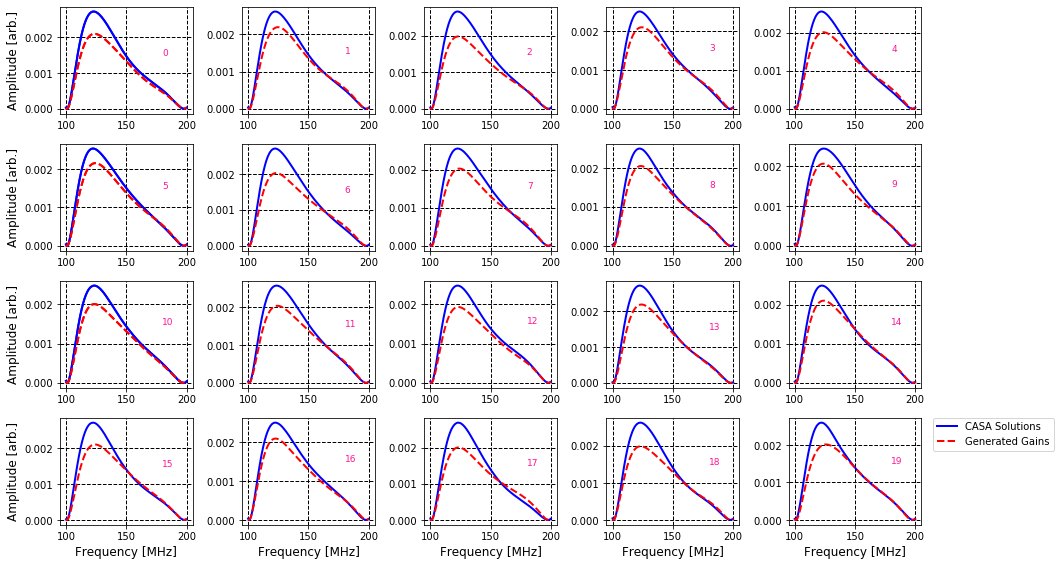

In [57]:
nrow,ncol = 4,5
numplots = nrow*ncol
ndays = len(npzlist)
iarr = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3]
jarr = [0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4]

f,axarr = plt.subplots(nrow,ncol,sharex=True,sharey=True,figsize=(15,8))
gs = gridspec.GridSpec(nrow,ncol)#, wspace=0.01, hspace=0.1)

for i,a in enumerate(good_ants[:20]):
    
    ax=plt.subplot(gs[iarr[i],jarr[i]])
    ax.annotate(str(a), xy=(180,0.0015), size=9, color='deeppink')

    for daynum in range(ndays):
        data = np.load(npzlist[daynum])
        xgain = np.abs(data['gains'][0,:,int(a)])
        ygain = np.abs(data['gains'][1,:,int(a)])
        
        
        depenvar =ygain
        depenvarmodel = yyants
        if i > 14:
            ax.set_xlabel('Frequency [MHz]',size=12)
            ax.grid(color='k', linestyle='--', linewidth=1)
        if i == 0:
            ax.set_ylabel('Amplitude [arb.]',size=12)
            ax.plot(freqs,depenvar,'b-',label='CASA Gain Solutions',lw=2)
            #ax.plot(freqs,np.abs(np.mean(true_gains[depenvarmodel[i]], axis=0)),
            #        'r--',label='Generated Gains',lw=2)
            ax.plot(freqs,np.abs(rmantphs_gen_bandpass[ants[i]]),'r--',label='Generated Gains',lw=2)
            
        if i == 5:
            ax.set_ylabel('Amplitude [arb.]',size=12)
            ax.plot(freqs,depenvar,'b-',label='CASA Solutions',lw=2)
            #ax.plot(freqs,np.abs(np.mean(true_gains[depenvarmodel[i]], axis=0)),
            #        'r--',label='Generated Gains',lw=2)
            #ax[0,0].set_title('Name')#gives plot at location (1,1) a title
            ax.plot(freqs,np.abs(rmantphs_gen_bandpass[ants[i]]),'r--',label='Generated Gains',lw=2)
            
        if i == 10:
            ax.set_ylabel('Amplitude [arb.]',size=12)
            ax.plot(freqs,depenvar,'b-',label='CASA Solutions',lw=2)
            #ax.plot(freqs,np.abs(np.mean(true_gains[depenvarmodel[i]], axis=0)),
            #        'r--',label='Generated Gains',lw=2)
            ax.plot(freqs,np.abs(rmantphs_gen_bandpass[ants[i]]),'r--',label='Generated Gains',lw=2)
         
        if i == 15:
            ax.set_ylabel('Amplitude [arb.]',size=12)
            ax.plot(freqs,depenvar,'b-',label='CASA Solutions',lw=2)
            #ax.plot(freqs,np.abs(np.mean(true_gains[depenvarmodel[i]], axis=0)),
            #        'r--',label='Generated Gains',lw=2)
            ax.plot(freqs,np.abs(rmantphs_gen_bandpass[ants[i]]),'r--',label='Generated Gains',lw=2)
        
        else:
            ax.plot(freqs,depenvar,'b-',label='CASA Solutions',lw=2)
            #ax.plot(freqs,np.abs(np.mean(true_gains[depenvarmodel[i]], axis=0)),
            #        'r--',label='Generated Gains',lw=2)
            ax.plot(freqs,np.abs(rmantphs_gen_bandpass[ants[i]]),'r--',label='Generated Gains',lw=2)
            ax.grid(color='k', linestyle='--', linewidth=1)

ax.legend(bbox_to_anchor=(2, 1), loc='upper right', borderaxespad=0.)
plt.tight_layout()
f.savefig(image_path+os.path.basename(bc)+'.1.png')
plt.show()

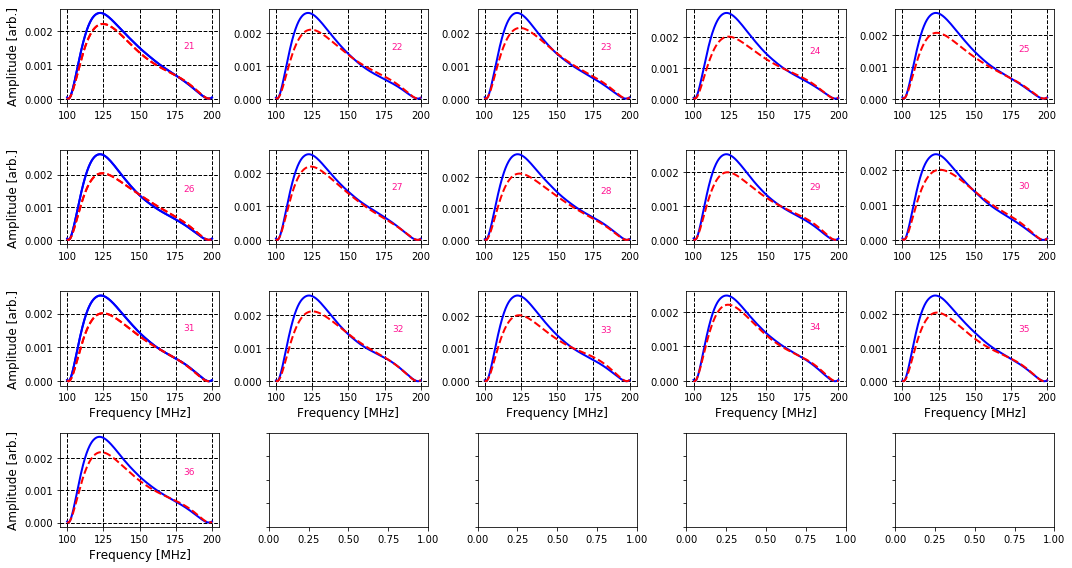

In [58]:
nrow,ncol = 4,5
numplots = nrow*ncol
ndays = len(npzlist)
iarr = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3]
jarr = [0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4]

f,axarr = plt.subplots(nrow,ncol,sharex=True,sharey=True,figsize=(15,8))
gs = gridspec.GridSpec(nrow,ncol)#, wspace=0.01, hspace=0.1)

for i,a in enumerate(good_ants[21:]):
    
    ax=plt.subplot(gs[iarr[i],jarr[i]])
    ax.annotate(str(a), xy=(180,0.0015), size=9, color='deeppink')

    for daynum in range(ndays):
        data = np.load(npzlist[daynum])
        xgain = np.abs(data['gains'][0,:,int(a)])
        ygain = np.abs(data['gains'][1,:,int(a)]) 
        
        depenvar =ygain
        depenvarmodel = yyants
        if i > 9:
            ax.set_xlabel('Frequency [MHz]',size=12)
            ax.grid(color='k', linestyle='--', linewidth=1)
        if i == 0:
            ax.set_ylabel('Amplitude [arb.]',size=12)
            ax.plot(freqs,depenvar,'b-',label='CASA Gain Solutions',lw=2)
            ax.plot(freqs,np.abs(rmantphs_gen_bandpass[depenvarmodel[i]]),
                    'r--',label='Generated Gains',lw=2)
        if i == 5:
            ax.set_ylabel('Amplitude [arb.]',size=12)
            ax.plot(freqs,depenvar,'b-',label='CASA Solutions',lw=2)
            ax.plot(freqs,np.abs(rmantphs_gen_bandpass[depenvarmodel[i]]),
                    'r--',label='Generated Gains',lw=2)
        
        if i == 10:
            ax.set_ylabel('Amplitude [arb.]',size=12)
            ax.plot(freqs,depenvar,'b-',label='CASA Solutions',lw=2)
            ax.plot(freqs,np.abs(rmantphs_gen_bandpass[depenvarmodel[i]]),
                    'r--',label='Generated Gains',lw=2)
         
        if i == 15:
            ax.set_ylabel('Amplitude [arb.]',size=12)
            ax.plot(freqs,depenvar,'b-',label='CASA Solutions',lw=2)
            ax.plot(freqs,np.abs(rmantphs_gen_bandpass[depenvarmodel[i]]),
                    'r--',label='Generated Gains',lw=2)
        
        else:
            ax.plot(freqs,depenvar,'b-',label='CASA Solutions',lw=2)
            ax.plot(freqs,np.abs(rmantphs_gen_bandpass[depenvarmodel[i]]),
                    'r--',label='Generated Gains',lw=2)
            ax.grid(color='k', linestyle='--', linewidth=1)

#ax.legend(bbox_to_anchor=(3.3, 0.8), loc='upper right', borderaxespad=0.)
plt.tight_layout()
f.savefig(image_path+os.path.basename(bc)+'.2.png')
plt.show()

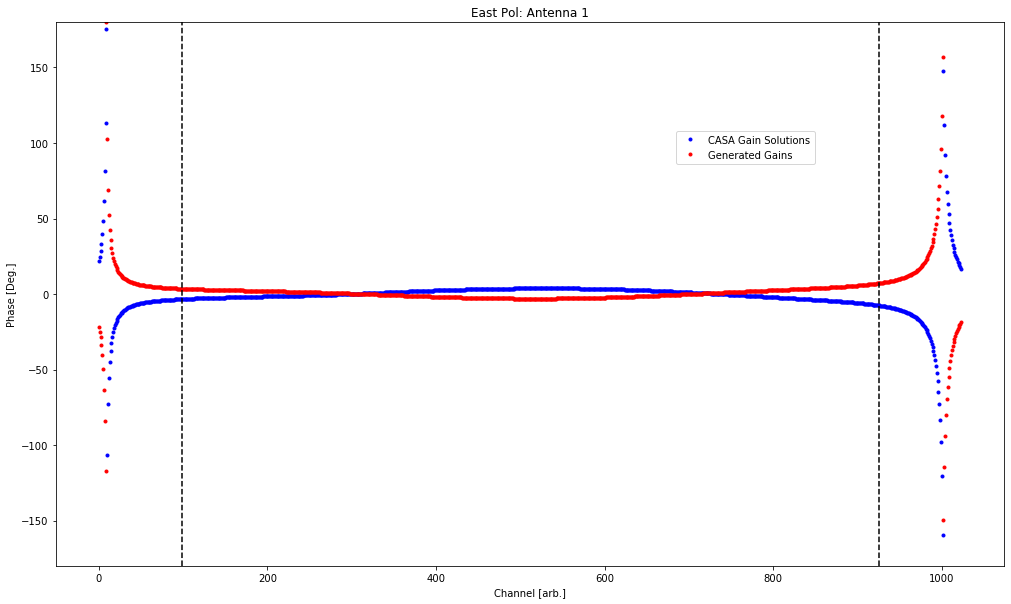

In [119]:
plt.figure(figsize=(17,10))
plt.title("East Pol: Antenna 1")
plt.plot(np.angle(d['gains'][0,:,2],deg=True),'b.',label='CASA Gain Solutions',lw=2)
#plt.plot(np.angle(np.mean(true_gains[yyants[1]], axis=0),deg=True),'r.',label='Generated Gains',lw=2)
plt.plot(np.angle(rmantphs_gen_bandpass[xxants[2]],deg=True),'r.',label='Generated Gains',lw=2)
plt.axvline(99, color='k', linestyle='--')
plt.axvline(925, color='k', linestyle='--')
plt.ylim(-180.,180.)
plt.xlabel('Channel [arb.]')
plt.ylabel('Phase [Deg.]')
plt.legend(bbox_to_anchor=(0.8, 0.8), loc='upper right', borderaxespad=0.)

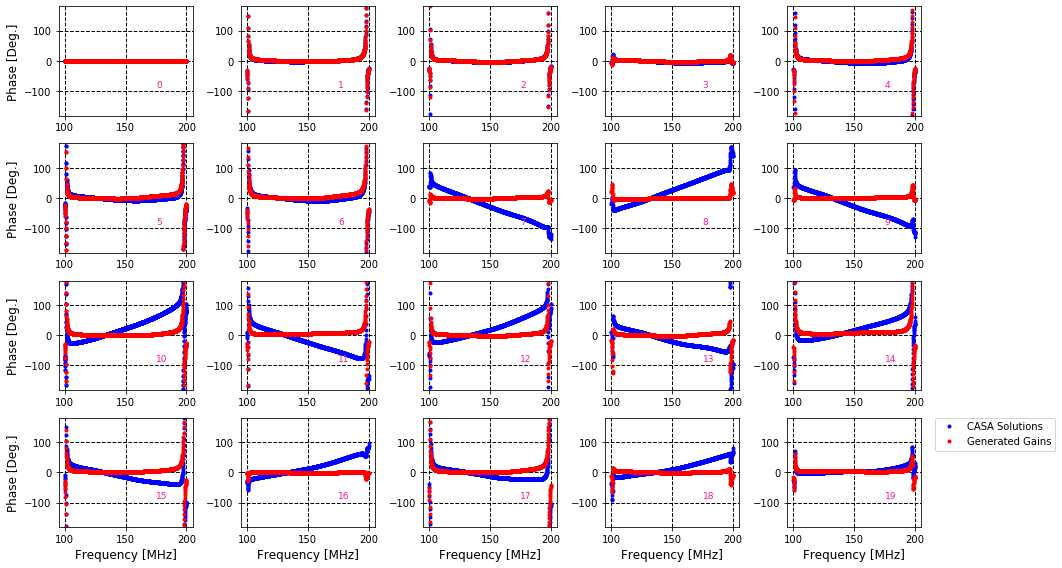

In [113]:
nrow,ncol = 4,5
numplots = nrow*ncol
ndays = len(npzlist)
iarr = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3]
jarr = [0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4]

f,axarr = plt.subplots(nrow,ncol,sharex=True,sharey=True,figsize=(15,8))
#f.suptitle("Product of Delay & Bandpass Solutions", fontsize=14)#Title centered above all subplots
gs = gridspec.GridSpec(nrow,ncol)#, wspace=0.01, hspace=0.1)

for i,a in enumerate(good_ants[:20]):
    
    #for ind in range(numplots):
    ax=plt.subplot(gs[iarr[i],jarr[i]])
    ax.set_ylim(-180.,180.)
    #ax.set_xlim(100,200)
    ax.annotate(str(a), xy=(175,-85), size=9, color='deeppink')
    ax.fill_between(freqs[201:300],-0.2,3.2, facecolor='k',alpha=0.2)
    ax.fill_between(freqs[581:680],-0.2,3.2,facecolor='k',alpha=0.2)

    for daynum in range(ndays):
        data = np.load(npzlist[daynum])
        xgain = -np.angle(data['gains'][0,:,int(a)],deg=True)
        ygain = -np.angle(data['gains'][1,:,int(a)],deg=True)
        
        
#print(list(msk_xgain))
        depenvar =xgain
        depenvarmodel = xxants
        if i > 14:
            ax.set_xlabel('Frequency [MHz]',size=12)
            ax.grid(color='k', linestyle='--', linewidth=1)
        if i == 0:
            ax.set_ylabel('Phase [Deg.]',size=12)
            ax.plot(freqs,depenvar,'b.',label='CASA Gain Solutions',lw=2)
            ax.plot(freqs, np.angle(rmantphs_gen_bandpass[depenvarmodel[i]],deg=True),
                    'r.',label='Generated Gains',lw=2)
        if i == 5:
            ax.set_ylabel('Phase [Deg.]',size=12)
            ax.plot(freqs,depenvar,'b.',label='CASA Solutions',lw=2)
            ax.plot(freqs, np.angle(rmantphs_gen_bandpass[depenvarmodel[i]],deg=True),
                    'r.',label='Generated Gains',lw=2)
        #ax[0,0].set_title('Name')#gives plot at location (1,1) a title
        if i == 10:
            ax.set_ylabel('Phase [Deg.]',size=12)
            ax.plot(freqs,depenvar,'b.',label='CASA Solutions',lw=2)
            ax.plot(freqs, np.angle(rmantphs_gen_bandpass[depenvarmodel[i]],deg=True),
                    'r.',label='Generated Gains',lw=2)
        if i == 15:
            ax.set_ylabel('Phase [Deg.]',size=12)
            ax.plot(freqs,depenvar,'b.',label='CASA Solutions',lw=2)
            ax.plot(freqs, np.angle(rmantphs_gen_bandpass[depenvarmodel[i]],deg=True),
                    'r.',label='Generated Gains',lw=2)
        else:
            ax.plot(freqs,depenvar,'b.',label='CASA Solutions',lw=2)
            ax.plot(freqs, np.angle(rmantphs_gen_bandpass[depenvarmodel[i]],deg=True),
                    'r.',label='Generated Gains',lw=2)
            ax.grid(color='k', linestyle='--', linewidth=1)

ax.legend(bbox_to_anchor=(2, 1), loc='upper right', borderaxespad=0.)
plt.tight_layout()
#f.savefig('2458115.24482.HH.uvOCR_BP.png')
plt.show()

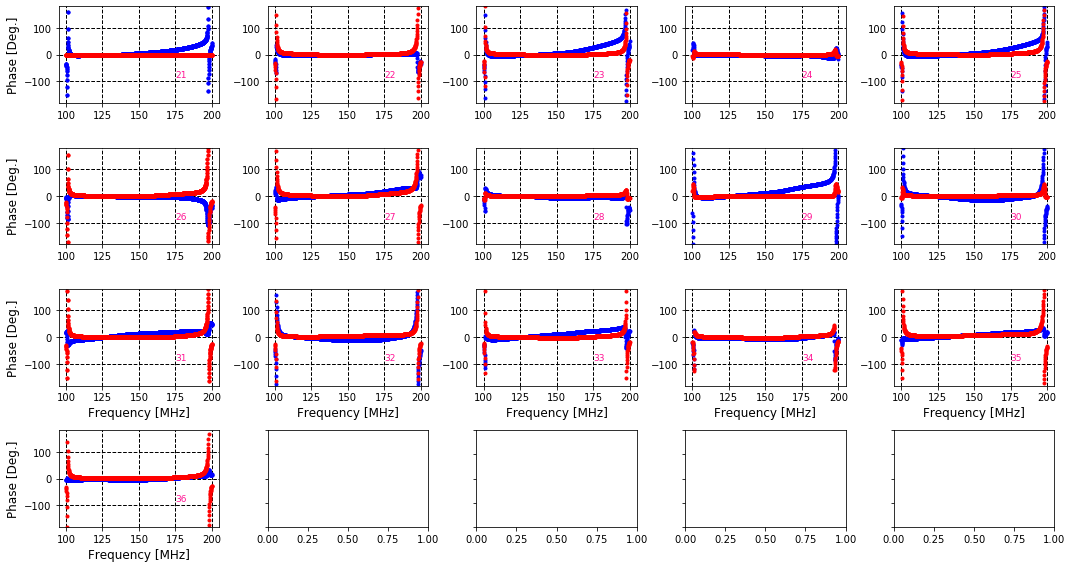

In [114]:
nrow,ncol = 4,5
numplots = nrow*ncol
ndays = len(npzlist)
iarr = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3]
jarr = [0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4]

#msk_spec = np.zeros((1024))

f,axarr = plt.subplots(nrow,ncol,sharex=True,sharey=True,figsize=(15,8))
#f.suptitle("Bandpass Solutions", fontsize=14)#Title centered above all subplots
gs = gridspec.GridSpec(nrow,ncol)#, wspace=0.01, hspace=0.1)

for i,a in enumerate(good_ants[21:]):
    
    #for ind in range(numplots):
    ax=plt.subplot(gs[iarr[i],jarr[i]])
    ax.set_ylim(-180.,180.)
    #ax.set_xlim(100,200)
    ax.annotate(str(a), xy=(175,-85), size=9, color='deeppink')
    ax.fill_between(freqs[201:300],-0.2,3.2, facecolor='k',alpha=0.2)
    ax.fill_between(freqs[581:680],-0.2,3.2,facecolor='k',alpha=0.2)

    for daynum in range(ndays):
        data = np.load(npzlist[daynum])
        xgain = -np.angle(data['gains'][0,:,int(a)],deg=True)
        ygain = -np.angle(data['gains'][1,:,int(a)],deg=True)
        
        
#print(list(msk_xgain))
        depenvar =xgain
        depenvarmodel = xxants
        if i > 9:
            ax.set_xlabel('Frequency [MHz]',size=12)
            ax.grid(color='k', linestyle='--', linewidth=1)
        if i == 0:
            ax.set_ylabel('Phase [Deg.]',size=12)
            ax.plot(freqs,depenvar,'b.',label='CASA Gain Solutions',lw=2)
            ax.plot(freqs, np.angle(rmantphs_gen_bandpass[depenvarmodel[i]],deg=True),
                    'r.',label='Generated Gains',lw=2)
        if i == 5:
            ax.set_ylabel('Phase [Deg.]',size=12)
            ax.plot(freqs,depenvar,'b.',label='CASA Solutions',lw=2)
            ax.plot(freqs, np.angle(rmantphs_gen_bandpass[depenvarmodel[i]],deg=True),
                    'r.',label='Generated Gains',lw=2)
        #ax[0,0].set_title('Name')#gives plot at location (1,1) a title
        if i == 10:
            ax.set_ylabel('Phase [Deg.]',size=12)
            ax.plot(freqs,depenvar,'b.',label='CASA Solutions',lw=2)
            ax.plot(freqs, np.angle(rmantphs_gen_bandpass[depenvarmodel[i]],deg=True),
                    'r.',label='Generated Gains',lw=2)
         
        if i == 15:
            ax.set_ylabel('Phase [Deg.]',size=12)
            ax.plot(freqs,depenvar,'b.',label='CASA Solutions',lw=2)
            ax.plot(freqs, np.angle(rmantphs_gen_bandpass[depenvarmodel[i]],deg=True),
                    'r.',label='Generated Gains',lw=2)
        
        else:
            ax.plot(freqs,depenvar,'b.',label='CASA Solutions',lw=2)
            ax.plot(freqs, np.angle(rmantphs_gen_bandpass[depenvarmodel[i]],deg=True),
                    'r.',label='Generated Gains',lw=2)
            ax.grid(color='k', linestyle='--', linewidth=1)

#ax.legend(bbox_to_anchor=(2, 1), loc='upper right', borderaxespad=0.)
plt.tight_layout()
#f.savefig('2458115.24482.HH.uvOCR_BP.png')
plt.show()

## Compare Combined Solutions

In [120]:
sum_phase = np.zeros_like(bp['gains'])


# Isolate xx and yy components
xxants=ants[0::2] # ants comes from the section called "Generate Uncalibrated Data" 
yyants=ants[1::2]

#for a in ants_val:
for a in xxants:
    sum_phase[0,:,a[0]] = d['gains'][0,:,a[0]].conj()*casa_delay[0,:,a[0]].conj()*offset[0,0,a[0]].conj()
    sum_phase[1,:,a[0]] = d['gains'][1,:,a[0]].conj()*casa_delay[0,:,a[0]].conj()*offset[1,0,a[0]].conj()
    

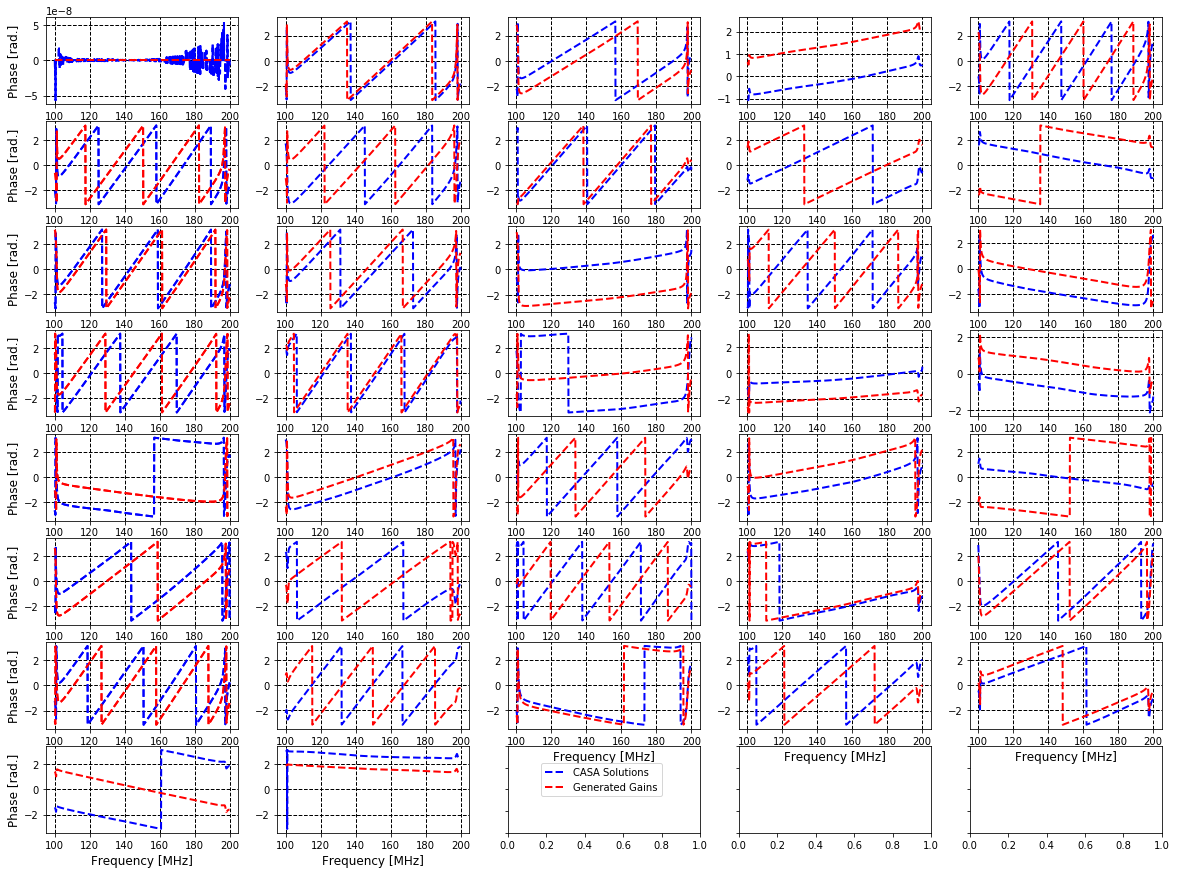

CPU times: user 4.37 s, sys: 50.8 ms, total: 4.42 s
Wall time: 4.43 s


In [122]:
%%time

nrow,ncol = 8,5
numplots = nrow*ncol
ndays = len(npzlist)
iarr = [0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5,6,6,6,6,6,7,7,7,7,7]
jarr = [0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4]

combine_data = np.angle(sum_phase, deg=False)

f,axarr = plt.subplots(nrow,ncol,sharex=True,sharey=True,figsize=(20,15))
gs = gridspec.GridSpec(nrow,ncol)#, wspace=0.01, hspace=0.1)

for i,a in enumerate(good_ants):
    
    ax=plt.subplot(gs[iarr[i],jarr[i]])

    for daynum in range(ndays):
        xgain = combine_data[0,:,int(a)]#np.angle(combine_data[0,:,int(a)], deg=True)
        ygain = combine_data[1,:,int(a)]#np.angle(combine_data[1,:,int(a)], deg=True)
        
        depenvar =xgain
        depenvarmodel = xxants
        if i > 14:
            ax.set_xlabel('Frequency [MHz]',size=12)
            ax.grid(color='k', linestyle='--', linewidth=1)
        if i == 0:
            ax.set_ylabel('Phase [rad.]',size=12)
            ax.plot(freqs,depenvar,'b--',label='CASA Gain Solutions',lw=2)
            #ax.plot(freqs,depenvar-np.angle(sum_phase[0,:,int(a)]/np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),'b--',label='CASA Solutions',lw=2)
            ax.plot(hd.freqs/1e6,np.angle(np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),
                    'r--',label='Generated Gains',lw=2)
            
        if i == 5:
            ax.set_ylabel('Phase [rad.]',size=12)
            ax.plot(freqs,depenvar,'b--',label='CASA Solutions',lw=2)
            #ax.plot(freqs,depenvar-np.angle(sum_phase[0,:,int(a)]/np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),'b--',label='CASA Solutions',lw=2)
            ax.plot(hd.freqs/1e6,np.angle(np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),
                    'r--',label='Generated Gains',lw=2)
            #ax[0,0].set_title('Name')#gives plot at location (1,1) a title
            
        if i == 10:
            ax.set_ylabel('Phase [rad.]',size=12)
            ax.plot(freqs,depenvar,'b--',label='CASA Solutions',lw=2)
            #ax.plot(freqs,depenvar-np.angle(sum_phase[0,:,int(a)]/np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),'b--',label='CASA Solutions',lw=2)
            ax.plot(hd.freqs/1e6,np.angle(np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),
                    'r--',label='Generated Gains',lw=2)
         
        if i == 15:
            ax.set_ylabel('Phase [rad.]',size=12)
            ax.plot(freqs,depenvar,'b--',label='CASA Solutions',lw=2)
            #ax.plot(freqs,depenvar-np.angle(sum_phase[0,:,int(a)]/np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),'b--',label='CASA Solutions',lw=2)
            ax.plot(hd.freqs/1e6,np.angle(np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),
                    'r--',label='Generated Gains',lw=2)
        
        if i > 19:
            ax.set_xlabel('Frequency [MHz]',size=12)
            ax.grid(color='k', linestyle='--', linewidth=1)
        if i == 20:
            ax.set_ylabel('Phase [rad.]',size=12)
            ax.plot(freqs,depenvar,'b--',label='CASA Gain Solutions',lw=2)
            #ax.plot(freqs,depenvar-np.angle(sum_phase[0,:,int(a)]/np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),'b--',label='CASA Solutions',lw=2)
            ax.plot(hd.freqs/1e6,np.angle(np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),
                    'r--',label='Generated Gains',lw=2)
        if i == 25:
            ax.set_ylabel('Phase [rad.]',size=12)
            ax.plot(freqs,depenvar,'b--',label='CASA Solutions',lw=2)
            #ax.plot(freqs,depenvar-np.angle(sum_phase[0,:,int(a)]/np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),'b--',label='CASA Solutions',lw=2)
            ax.plot(hd.freqs/1e6,np.angle(np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),
                    'r--',label='Generated Gains',lw=2)
            
        if i == 30:
            ax.set_ylabel('Phase [rad.]',size=12)
            ax.plot(freqs,depenvar,'b--',label='CASA Solutions',lw=2)
            #ax.plot(freqs,depenvar-np.angle(sum_phase[0,:,int(a)]/np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),'b--',label='CASA Solutions',lw=2)
            ax.plot(hd.freqs/1e6,np.angle(np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),
                    'r--',label='Generated Gains',lw=2)
         
        if i == 35:
            ax.set_ylabel('Phase [rad.]',size=12)
            ax.plot(freqs,depenvar,'b--',label='CASA Solutions',lw=2)
            #ax.plot(freqs,depenvar-np.angle(sum_phase[0,:,int(a)]/np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),'b--',label='CASA Solutions',lw=2)
            ax.plot(hd.freqs/1e6,np.angle(np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),
                    'r--',label='Generated Gains',lw=2)
        else:
            ax.plot(freqs,depenvar,'b--',label='CASA Solutions',lw=2)
            #ax.plot(freqs,depenvar-np.angle(sum_phase[0,:,int(a)]/np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),'g--',label='CASA Solutions',lw=2)
            ax.plot(hd.freqs/1e6,np.angle(np.mean(rmantphs_true_gains[depenvarmodel[i]], axis=0),deg=False),
                    'r--',label='Generated Gains',lw=2)
            ax.grid(color='k', linestyle='--', linewidth=1)
ax.legend(bbox_to_anchor=(2, 0.8), loc='upper right', borderaxespad=0.)
#plt.tight_layout()
f.savefig('/Users/tashaleebillings/Desktop/Research/images/combinedKGphsB_eastpol.phs.png')
plt.show()